In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import sys
import glob
import gzip
import io

from Bio import SearchIO

from IPython.display import display, clear_output

In [11]:
gtdb_md = pd.read_csv('/data/mhoffert/genomes/GTDB_r207/bac120_metadata_r207.tsv', sep='\t', index_col=0)


Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.


In [12]:
gtdb_reps_md = gtdb_md[gtdb_md.gtdb_representative.eq('t')]

taxonomy_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
gtdb_taxonomy = gtdb_reps_md.gtdb_taxonomy.apply(lambda x: pd.Series(index=taxonomy_levels,
                                                            data=[s.split('_')[-1] for s in x.split(';')]))

In [2]:
protein_fastas = glob.glob('/data/mhoffert/genomes/GTDB_r207/protein_faa_reps/bacteria/*.faa')

In [ ]:
# commenting to avoid rerunning
# hmm_db = '/data/mhoffert/tools/HMM_CFP/CFP.HMM'
# output_path = '/data/mhoffert/fiererlab/periodic_phyla/results/CFP_gapseq/'
# for count, protein_file in enumerate(protein_fastas):
#     genome_id = protein_file.split('/')[-1].split('_protein')[0]
#     display(count)
#     clear_output(wait=True)
#     os.system(f'hmmsearch --tblout {output_path}{genome_id}_tblout.txt -o {output_path}{genome_id}_hmmout.txt --cpu 4 -E 0.01 {hmm_db} {protein_file}')
#     os.system(f'gzip {output_path}{genome_id}_*.txt')

29245

In [4]:
hmm_results = glob.glob('/data/mhoffert/fiererlab/periodic_phyla/results/CFP_gapseq/*tblout*')

In [5]:
len(hmm_results)

62291

In [6]:
attribs = ['id', 'accession', 'bias', 'bitscore', 'description', 'cluster_num', 'domain_exp_num',  'domain_included_num', 'domain_obs_num', 'domain_reported_num', 'env_num', 'evalue', 'overlap_num', 'region_num']

def read_tbl(filepath):
    hits = {}
    with gzip.open(filepath, 'rb') as handle:
        content =  io.StringIO(handle.read().decode())
    hits['hmm_id'] = []
    # for each query (each hmm)
    for queryresult in SearchIO.parse(content, 'hmmer3-tab'):
        # for each hit (gene which hit the hmm)
        for hit in queryresult.hits:
            hits['hmm_id'].append(queryresult.id)
            for attrib in attribs:
                if attrib in hits.keys():
                    hits[attrib].append(getattr(hit, attrib))
                else:
                    hits[attrib] = []
                    hits[attrib].append(getattr(hit, attrib))

    parsed = pd.DataFrame.from_dict(hits)
    
    return parsed

In [7]:
hit_genomes = []
count = 1
for h in hmm_results:
    tbl = read_tbl(h)
    if count % 100 == 0:
        display(count, len(hit_genomes))
        clear_output(wait=True)
    if len(tbl) > 0:
        if len(tbl[tbl['evalue'] < 1e-99]) > 0:
            hit_genomes.append(h.split('/')[-1].split('_tblout')[0])
    count += 1
        

62200

10152

In [8]:
len(hit_genomes)

10166

In [47]:
commands = []
base_path = '/data/mhoffert/fiererlab/periodic_phyla/results/CFP_gapseq/'
genome_path = '/data/mhoffert/genomes/GTDB_r207/protein_fna_reps/bacteria/'
pathways = 'CALVIN-PWY|CODH-PWY|PWY-7784|P23-PWY|PWY-5392|PWY-5789|PWY-5743'
count = 1
for p in hit_genomes:
    if count % 1000 == 0:
        display(count, p)
    command = f'./../gapseq find -p "({pathways})" -t Bacteria -b 100 -a -l metacyc -K 1 -j -O -M nucl -f {base_path} {genome_path}{p}_protein.fna'
    with open(f'/data/mhoffert/tools/gapseq/CFP_gapseq_jobs/j{count}.sh', 'w') as handle:
        handle.write('#!/bin/bash\n')
        handle.write(f'{command}\n')
        
    count += 1
    commands.append(command)
    

1000

'GB_GCA_000063525.1'

2000

'GB_GCA_002703045.1'

3000

'RS_GCF_900232995.1'

4000

'GB_GCA_900112915.1'

5000

'GB_GCA_015207585.1'

6000

'RS_GCF_003112775.1'

7000

'GB_GCA_002697205.1'

8000

'GB_GCA_003449595.1'

9000

'GB_GCA_018240795.1'

10000

'GB_GCA_016716965.1'

In [48]:
with open('/data/mhoffert/tools/gapseq/CFP_gapseq.sh', 'w') as handle:
    handle.write('#!/bin/bash\n')
    handle.write('\n'.join(commands))

### Running command
printf '%s\0' j{1..10166}.sh | xargs -0 -n1 -P20 sh -c './"$1"' _

## Compiling results

In [5]:
pathway_name_map = {'CALVIN-PWY': 'Calvin Cycle',
'CODH-PWY': 'rAcoA homoacetogenic',
'PWY-7784': 'rAcoA methanogenic',
'P23-PWY' :'rTCA I',
'PWY-5392': 'rTCA II',
'PWY-5789': '3HP/4HB',
'PWY-5743': '3HP bicycle'}


In [1]:
table_thresholds = {'CALVIN-PWY':90, 'CODH-PWY':95, 'PWY-7784':90, 'P23-PWY':90, 'PWY-5392':80, 'PWY-5789':90, 'PWY-5743':82}

In [2]:
for key, item in table_thresholds.items():
    print(key, item)

CALVIN-PWY 90
CODH-PWY 95
PWY-7784 90
P23-PWY 90
PWY-5392 80
PWY-5789 90
PWY-5743 82


In [7]:
gapseq_results = glob.glob('/data/mhoffert/fiererlab/periodic_phyla/results/CFP_gapseq/*-Pathways.tbl*')

In [8]:
len(gapseq_results)

10166

In [9]:
all_gapseq_results = []
count = 1
for g in gapseq_results:
    if count % 100 == 0:
        display(count)
        clear_output(wait=True)
    genome = g.split('/')[-1].split('_protein')[0]
    tbl = pd.read_csv(g, skiprows=3, sep='\t').assign(genome=genome)
    tbl['ID'] = tbl['ID'].apply(lambda x: x.replace('|', ''))
    all_gapseq_results.append(tbl)
    count += 1
    
gapseq_tbl = pd.concat(all_gapseq_results)

10100

In [13]:
# performing adjustments to completeness values
gapseq_tbl['pwy_name'] = gapseq_tbl['ID'].map(pathway_name_map)
gapseq_tbl['pwy_threshold'] = gapseq_tbl['ID'].map(table_thresholds)
gapseq_tbl['genome_completeness'] = gapseq_tbl['genome'].apply(lambda x: gtdb_reps_md.loc[x, 'checkm_completeness'] / 100)
gapseq_tbl['adjusted_completeness'] = gapseq_tbl['Completeness'] / gapseq_tbl['genome_completeness']
gapseq_tbl['fillval'] = 1

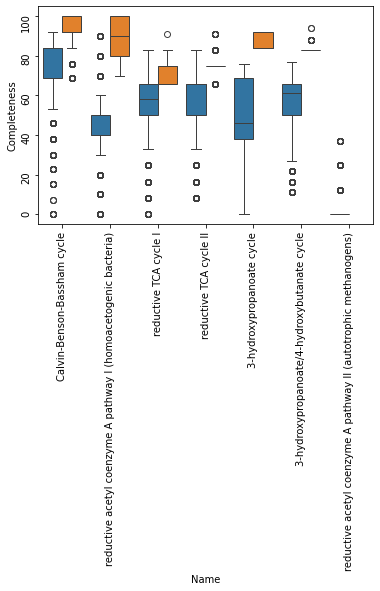

In [31]:
# plot of completeness distribution for the Calvin Cycle
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=gapseq_tbl, x='Name', y='Completeness', hue='Prediction')
ax.get_legend().remove()
plt.tick_params(rotation=90)

In [27]:
gapseq_tbl.head()

,ID,Name,Prediction,Completeness,VagueReactions,KeyReactions,KeyReactionsFound,ReactionsFound,genome,pwy_name,pwy_threshold,genome_completeness,adjusted_completeness,fillval
0,CALVIN-PWY,Calvin-Benson-Bassham cycle,False,92,0,1,0,PHOSGLYPHOS-RXN 1.2.1.13-RXN TRIOSEPISOMERIZAT...,RS_GCF_000006945.2,Calvin Cycle,90,1.0,92.0,1
1,CODH-PWY,reductive acetyl coenzyme A pathway I (homoace...,False,50,0,2,2,FORMATE-DEHYDROGENASE-NADP+-RXN 1.5.1.20-RXN M...,RS_GCF_000006945.2,rAcoA homoacetogenic,95,1.0,50.0,1
2,P23-PWY,reductive TCA cycle I,False,75,0,1,0,FUMHYDR-RXN SUCCCOASYN-RXN ACONITATEHYDR-RXN A...,RS_GCF_000006945.2,rTCA I,90,1.0,75.0,1
3,PWY-5392,reductive TCA cycle II,False,75,1,2,1,FUMHYDR-RXN SUCCCOASYN-RXN ACONITATEHYDR-RXN A...,RS_GCF_000006945.2,rTCA II,80,1.0,75.0,1
4,PWY-5743,3-hydroxypropanoate cycle,False,53,0,0,0,RXN-8974 RXN-8964 MALYL-COA-LYASE-RXN RXN-6383...,RS_GCF_000006945.2,3HP bicycle,82,1.0,53.0,1


In [19]:
gapseq_piv = gapseq_tbl[gapseq_tbl['adjusted_completeness'] >= gapseq_tbl['pwy_threshold']].pivot_table(index='genome', columns='pwy_name', values='fillval').fillna(0)

In [22]:
gapseq_piv['Calvin Cycle'].sum()

4851.0

In [33]:
gapseq_piv.sum().sum()

6511.0

In [12]:
import sys
sys.setrecursionlimit(100000)

(5679, 6)


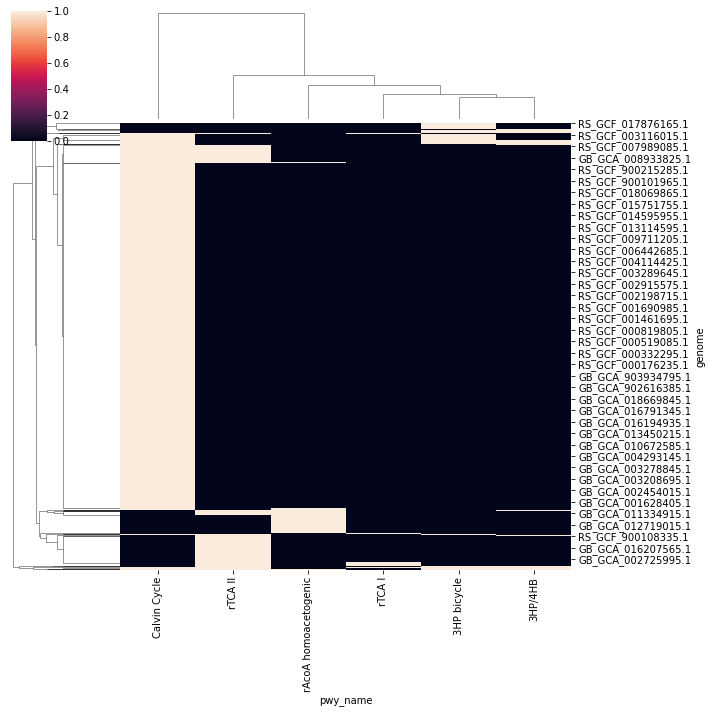

In [13]:
# gapseq_piv_cutoff = gapseq_piv >= 80
print(gapseq_piv.shape)
sns.clustermap(gapseq_piv)

## Saving data

In [17]:
gapseq_piv.reindex(gtdb_reps_md.index).fillna(0).to_csv('/data/mhoffert/fiererlab/periodic_phyla/results/full_gtdb_carbon_fixation_v2.tsv.gz', compression='gzip', sep='\t')

### Spot checking particular taxa

#### Cyanobacteria

In [18]:
# calvin cycle completeness in Cyanobacteria
cyanos = [s for s in gapseq_tbl['genome'].unique() if 'p__Cyanobacteria' in gtdb_md.loc[s, 'gtdb_taxonomy']]
print('Number of assessed cyanobacteria:', len(cyanos))

Number of assessed cyanobacteria: 855


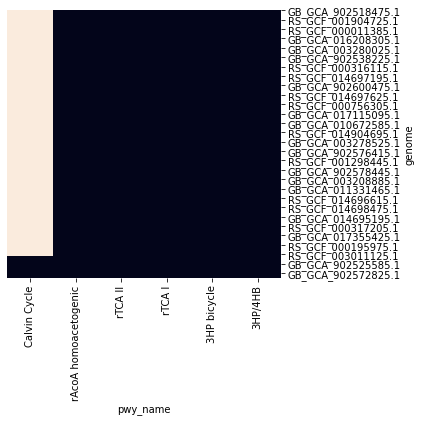

In [314]:
g =sns.clustermap(gapseq_piv.reindex(index=cyanos).fillna(0), dendrogram_ratio=0.01, figsize=(6,6))
g.ax_cbar.remove()
g.ax_col_dendrogram.remove()
g.ax_row_dendrogram.remove()

In [315]:
neg_cyanos = [s for s in cyanos if not s in gapseq_piv.index]

In [316]:
print('num negative', len(neg_cyanos), 'num positive', len(pos_cyanos))

num negative 68 num positive 787


<AxesSubplot:ylabel='checkm_completeness'>

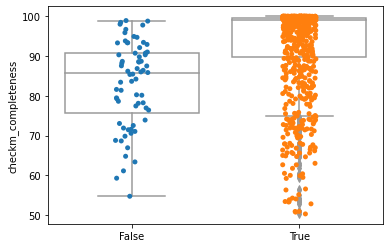

In [317]:
sns.boxplot(x=pd.Series(index=cyanos, data=[s in pos_cyanos for s in cyanos]),
            y=gtdb_reps_md.loc[cyanos, 'checkm_completeness'], color='white')

sns.stripplot(x=pd.Series(index=cyanos, data=[s in pos_cyanos for s in cyanos]),
            y=gtdb_reps_md.loc[cyanos, 'checkm_completeness'])

# sns.swarmplot(x=pd.Series(index=all_cyanos, data=[s in cyanos for s in all_cyanos]),
#             y=gtdb_reps_md.loc[all_cyanos, 'checkm_completeness'])

#### Chloroflexota

In [318]:
# calvin cycle completeness in Cyanobacteria
chloros = [s for s in gapseq_tbl['genome'].unique() if 'o__Chloroflexales' in gtdb_md.loc[s, 'gtdb_taxonomy']]
print('Number of assessed Chloroflexales:', len(chloros))

Number of assessed Chloroflexales: 26


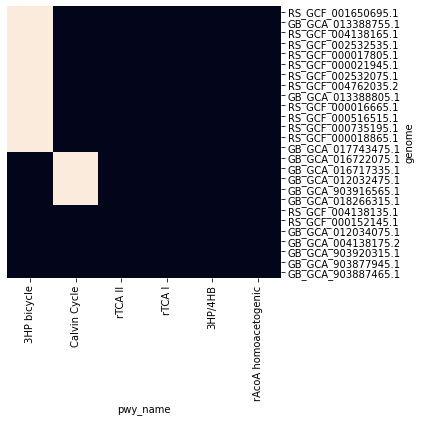

In [319]:
g =sns.clustermap(gapseq_piv.reindex(index=chloros).fillna(0), dendrogram_ratio=0.01, figsize=(6,6))
g.ax_cbar.remove()
g.ax_col_dendrogram.remove()
g.ax_row_dendrogram.remove()

In [320]:
chloro_calvin = (gapseq_piv.loc[[s for s in chloros if s in gapseq_piv.index], 'Calvin Cycle'] == 1)
chloro_bicycle = (gapseq_piv.loc[[s for s in chloros if s in gapseq_piv.index], '3HP bicycle'] == 1)
pos_chloros = chloro_calvin[chloro_calvin | chloro_bicycle].index
neg_chloros = chloro_calvin[~(chloro_calvin | chloro_bicycle)].index

In [321]:
print('num negative', len(neg_chloros), 'num positive', len(chloros))

num negative 0 num positive 26


<AxesSubplot:ylabel='checkm_completeness'>

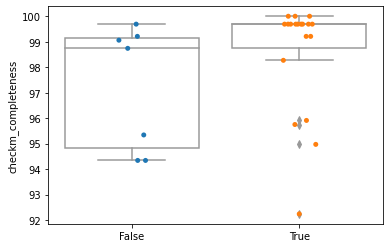

In [322]:
sns.boxplot(x=pd.Series(index=chloros, data=[s in pos_chloros for s in chloros]),
            y=gtdb_reps_md.loc[chloros, 'checkm_completeness'], color='white')

sns.stripplot(x=pd.Series(index=chloros, data=[s in pos_chloros for s in chloros]),
            y=gtdb_reps_md.loc[chloros, 'checkm_completeness'])

# sns.swarmplot(x=pd.Series(index=all_cyanos, data=[s in cyanos for s in all_cyanos]),
#             y=gtdb_reps_md.loc[all_cyanos, 'checkm_completeness'])

Others?

### Spot checking pathways

In [323]:
top_phyla = gtdb_reps_md['gtdb_taxonomy'].apply(lambda x: x.split(';')[1]).value_counts().head(10).index

In [324]:
for phylum in top_phyla:
    phyla_members = gtdb_md[gtdb_md['gtdb_representative'].eq('t') & gtdb_md['gtdb_taxonomy'].str.contains(phylum)].index
    num_total = len(phyla_members)
    for cycle in gapseq_piv.columns:
        cycle_positive = gapseq_piv.index[gapseq_piv[cycle] > 0]
        num_positive = len([s for s in cycle_positive if s in phyla_members])
        if num_positive > 0:
            print(phylum, num_total, cycle, num_positive, f'{num_positive / num_total * 100:.2f}%')
    print()

p__Proteobacteria 17350 3HP bicycle 241 1.39%
p__Proteobacteria 17350 3HP/4HB 123 0.71%
p__Proteobacteria 17350 Calvin Cycle 3486 20.09%
p__Proteobacteria 17350 rAcoA homoacetogenic 14 0.08%
p__Proteobacteria 17350 rTCA I 33 0.19%
p__Proteobacteria 17350 rTCA II 307 1.77%

p__Bacteroidota 8588 Calvin Cycle 4 0.05%
p__Bacteroidota 8588 rTCA I 4 0.05%
p__Bacteroidota 8588 rTCA II 6 0.07%

p__Firmicutes_A 8243 3HP bicycle 1 0.01%
p__Firmicutes_A 8243 3HP/4HB 3 0.04%
p__Firmicutes_A 8243 Calvin Cycle 5 0.06%
p__Firmicutes_A 8243 rAcoA homoacetogenic 9 0.11%
p__Firmicutes_A 8243 rTCA II 3 0.04%

p__Actinobacteriota 7328 3HP bicycle 28 0.38%
p__Actinobacteriota 7328 3HP/4HB 14 0.19%
p__Actinobacteriota 7328 Calvin Cycle 359 4.90%
p__Actinobacteriota 7328 rAcoA homoacetogenic 24 0.33%
p__Actinobacteriota 7328 rTCA I 23 0.31%
p__Actinobacteriota 7328 rTCA II 116 1.58%

p__Firmicutes 13543 3HP bicycle 3 0.02%
p__Firmicutes 13543 3HP/4HB 6 0.04%
p__Firmicutes 13543 Calvin Cycle 24 0.18%
p__Firmi

In [1]:
## Saving data

## Case studies

### Cyanobacteria

In [175]:
# calvin cycle completeness in Cyanobacteria
gapseq_cyanos = [s for s in gapseq_piv.index if 'c__Cyanobacteriia' in gtdb_md.loc[s, 'gtdb_taxonomy']]

In [176]:
temp_gapseq_counts = gtdb_reps_md.loc[gapseq_cyanos, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[4]).value_counts().head(15)

In [177]:
# how many reps are there?
counts = gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('c__Cyanobacteriia')]['gtdb_taxonomy'].apply(lambda x: x.split(';')[3]).value_counts()

In [181]:
all_cyanos = gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('c__Cyanobacteriia')].index
print(len(all_cyanos), 'total')
gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('c__Cyanobacteriia')]['gtdb_taxonomy'].apply(lambda x: x.split(';')[3]).value_counts().head()

1113 total


o__PCC-6307            525
o__Cyanobacteriales    411
o__Phormidesmiales      49
o__Elainellales         29
o__Pseudanabaenales     27
Name: gtdb_taxonomy, dtype: int64

In [182]:
print(temp_gapseq_counts.sum(), 'total assessed')
temp_gapseq_counts #.divide(counts, 1)

818 total assessed


f__Cyanobiaceae              429
f__Nostocaceae               176
f__Phormidesmiaceae           46
f__Microcoleaceae             41
f__Elainellaceae              27
f__Pseudanabaenaceae          19
f__Leptolyngbyaceae           19
f__Chroococcidiopsidaceae     13
f__Xenococcaceae              11
f__Coleofasciculaceae         10
f__Rubidibacteraceae           8
f__Cyanobacteriaceae           5
f__Microcystaceae_A            5
f__Spirulinaceae               5
f__Phormidiaceae_A             4
Name: gtdb_taxonomy, dtype: int64

In [202]:
# would more genomes have been included at a lower threshold?
# hit_genomes = []
cyano_tbls = []
count = 1
hit_count = 0
for h in hmm_results:
    genome = h.split('/')[-1].split('_tblout')[0]
    if genome in all_cyanos:
        tbl = read_tbl(h)

        if len(tbl) > 0:
            if len(tbl[tbl['evalue'] < 1e-10]) > 0:
                cyano_tbls.append(tbl.assign(genome=genome))
                hit_count += 1
            # hit_genomes.append(h.split('/')[-1].split('_tblout')[0])
    count += 1

In [203]:
all_cyano_tbls = pd.concat(cyano_tbls)

In [204]:
all_cyano_tbls['present'] = 1

(1094, 9)


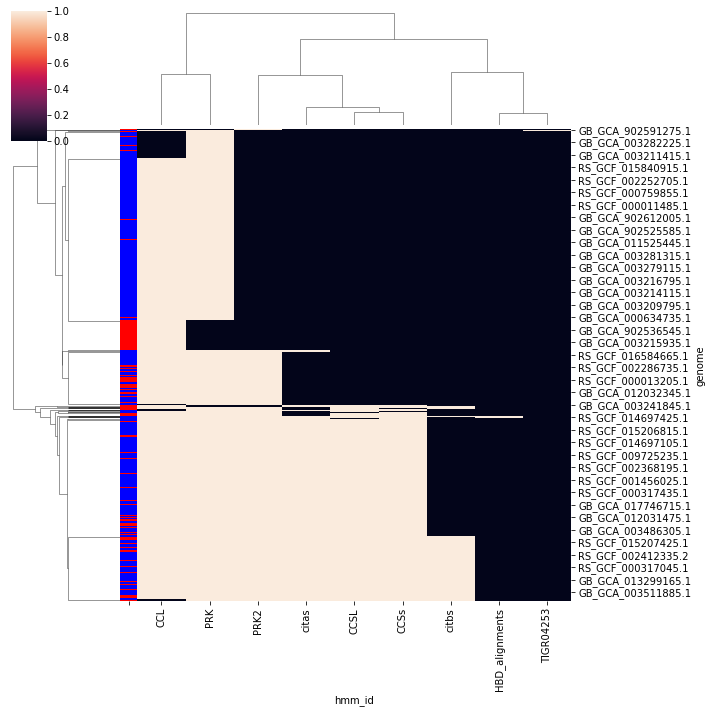

In [217]:
cyano_clustermap_data = all_cyano_tbls[all_cyano_tbls.evalue < 1e-10].groupby(['genome', 'hmm_id']).first()['present'].unstack().fillna(0)
print(cyano_clustermap_data.shape)
sns.clustermap(cyano_clustermap_data, row_colors=pd.Series(index=cyano_clustermap_data.index, data=[s in cyanos for s in cyano_clustermap_data.index]).map({True:'b', False:'r'}))

### Chloroflexota

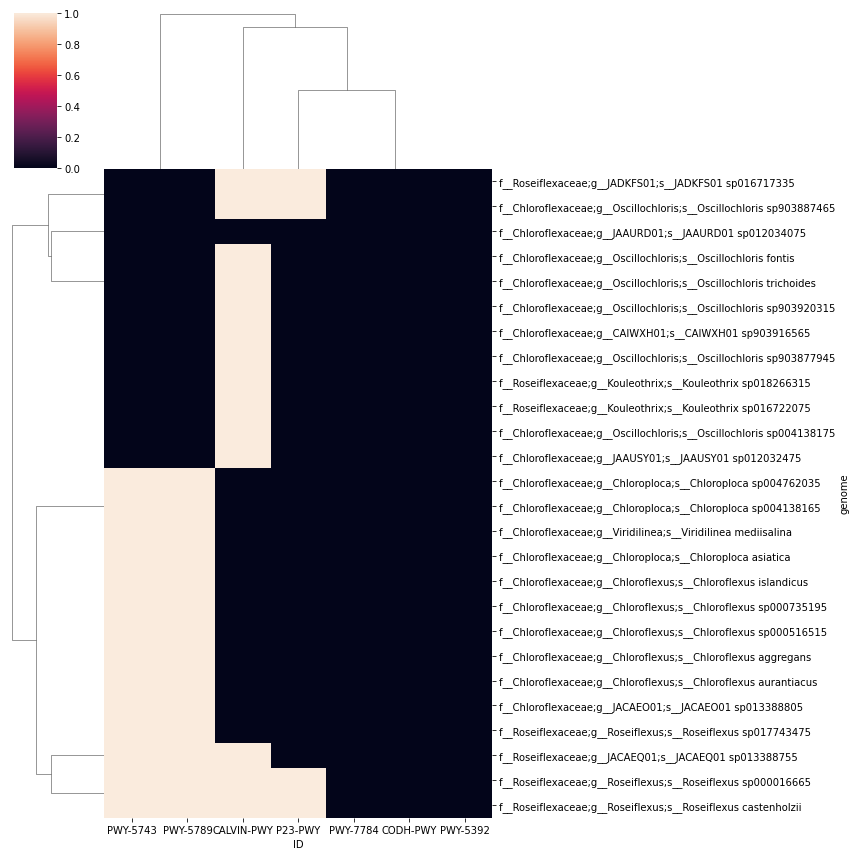

In [227]:
rename = gtdb_reps_md.loc[gapseq_chloroflexi, 'gtdb_taxonomy'].apply(lambda x: ';'.join(x.split(';')[4:]))
sns.clustermap((gapseq_piv.loc[gapseq_chloroflexi, :] > 80).rename(index=rename), figsize=(12,12))

In [137]:
# calvin cycle completeness in Cyanobacteria
gapseq_chloroflexi = [s for s in gapseq_piv.index if 'o__Chloroflexales' in gtdb_md.loc[s, 'gtdb_taxonomy']]

In [151]:
temp_gapseq_counts = gtdb_reps_md.loc[gapseq_chloroflexi, 'gtdb_taxonomy'].apply(lambda x: x.split(';')[4]).value_counts().head(15)

In [152]:
# how many reps are there?
counts = gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('o__Chloroflexales')]['gtdb_taxonomy'].apply(lambda x: x.split(';')[4]).value_counts()

In [153]:
all_chloroflexales = gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('o__Chloroflexales')].index
print(len(all_chloroflexales), 'total')
gtdb_reps_md[gtdb_reps_md['gtdb_taxonomy'].str.contains('o__Chloroflexales')]['gtdb_taxonomy'].apply(lambda x: x.split(';')[4]).value_counts()

55 total


f__Chloroflexaceae       26
f__Roseiflexaceae        19
f__Herpetosiphonaceae    10
Name: gtdb_taxonomy, dtype: int64

In [162]:
print(temp_gapseq_counts.sum(), 'total assessed')
temp_gapseq_counts #.divide(counts, 1)

26 total assessed


f__Chloroflexaceae    19
f__Roseiflexaceae      7
Name: gtdb_taxonomy, dtype: int64

In [167]:
# would more genomes have been included at a lower threshold?
# hit_genomes = []
count = 1
hit_count = 0
for h in hmm_results:
    genome = h.split('/')[-1].split('_tblout')[0]
    if genome in all_chloroflexales:
        tbl = read_tbl(h)

        if len(tbl) > 0:
            if len(tbl[tbl['evalue'] < 1e-10]) > 0:
                hit_count += 1
            # hit_genomes.append(h.split('/')[-1].split('_tblout')[0])
    count += 1

In [168]:
hit_count

55

In [147]:
hmm_results[0]

'/data/mhoffert/fiererlab/periodic_phyla/results/CFP_gapseq/RS_GCF_003697165.2_tblout.txt.gz'